In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import(
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

In [3]:
# Carregando o arquivo:
df = pd.read_csv('weather_data.csv')

# Transformando a coluna 'TS' no formato datetime:
df['TS'] = pd.to_datetime(df['TS'])

# Colocando a variável 'TS' como indice do nosso dataframe:
df.set_index('TS', inplace=True)

# Tratamento de outliers:

# Sabemos que os limites da umidade relativa é de 0% a 100%: 
limite_inferior_RH = 0
limite_superior_RH = 100

outliers_RH = (df['RH'] < limite_inferior_RH) | (df['RH'] > limite_superior_RH)

# Agora vamos tratar os outliers da temperatura ambiente. 
# O aceitável é uma temperatura ambiente entre 20°C e um pouco mais de 30°C.
IQR_TAMB = df['TAMB'].quantile(0.75) - df['TAMB'].quantile(0.25)
limite_inferior_TAMB = df['TAMB'].quantile(0.05) # 95% dos dados estão acima desse quartil 
limite_superior_TAMB = df['TAMB'].quantile(0.75) + (1.5 * IQR_TAMB)
outliers_TAMB = (df['TAMB'] <= limite_inferior_TAMB) | (df['TAMB'] >= limite_superior_TAMB)
limite_inferior_TAMB, limite_superior_TAMB

# Dataframe flitrado:
outliers = (outliers_RH | outliers_TAMB)
df_limpo = df[~outliers]
df_limpo

# Criando uma variável para os registros mensais:
df_mensal = df_limpo.copy()
df_mensal = df_mensal.resample('M').mean()

# Criando uma variável para os registros diarios:
df_diario = df_limpo.copy()
df_diario = df_diario.resample('D').mean()

# Substituindo os valores NaN do df_diario:
df_diario = df_diario.apply(lambda col: col.fillna(col.mean()), axis=0)

/tmp/ipykernel_10567/3686742295.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df_mensal.resample('M').mean()


In [4]:
IQR_GHI = df['GHI'].quantile(0.75) - df['GHI'].quantile(0.25)
limite_inferior_GHI = 0 
limite_superior_GHI = df['GHI'].quantile(0.75) + (1.5 * IQR_GHI)
outliers_GHI = (df['GHI'] <= limite_inferior_GHI) | (df['GHI'] >= limite_superior_GHI)
limite_inferior_GHI, limite_superior_GHI

(0, 1082.0)

In [5]:
df_abril = df_diario[df_diario.index.month == 4]
df_abril

,RH,TAMB,GHI
TS,,,
2024-04-10,89.567144,26.355476,159.156764
2024-04-11,89.512089,26.349825,163.468903
2024-04-12,88.047847,26.706389,240.848264
2024-04-13,90.931579,26.293985,178.477026
2024-04-14,76.634982,26.310754,243.072086
2024-04-15,76.634982,26.310754,243.072086
2024-04-16,76.634982,26.310754,243.072086
2024-04-17,76.634982,26.310754,243.072086
2024-04-18,76.634982,26.310754,243.072086


/tmp/ipykernel_10567/2818051425.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_mensal.index.strftime('%b-%Y'), rotation=45)


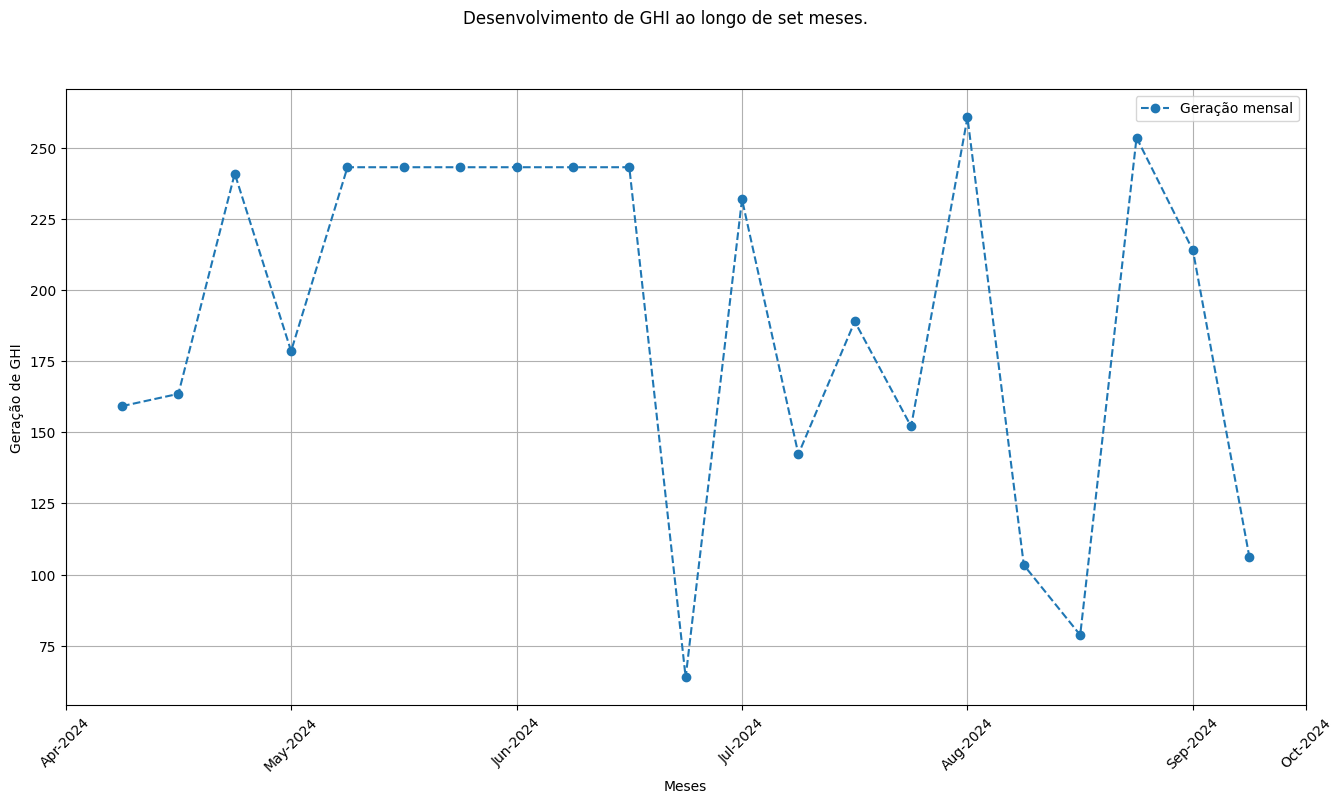

In [6]:
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Desenvolvimento de GHI ao longo de set meses.')
ax.plot(df_abril['GHI'], label='Geração mensal', marker='o', linestyle='--')
ax.set_xlabel('Meses')
ax.set_ylabel('Geração de GHI')
ax.set_xticklabels(df_mensal.index.strftime('%b-%Y'), rotation=45)  
ax.legend()
plt.grid(True)
plt.show()

In [7]:
matriz_de_correlacao = df_limpo.corr()

In [8]:
matriz_de_correlacao

,RH,TAMB,GHI
RH,1.000000,-0.885308,-0.805580
TAMB,-0.885308,1.000000,0.842909
GHI,-0.805580,0.842909,1.000000


In [9]:
import seaborn as sns

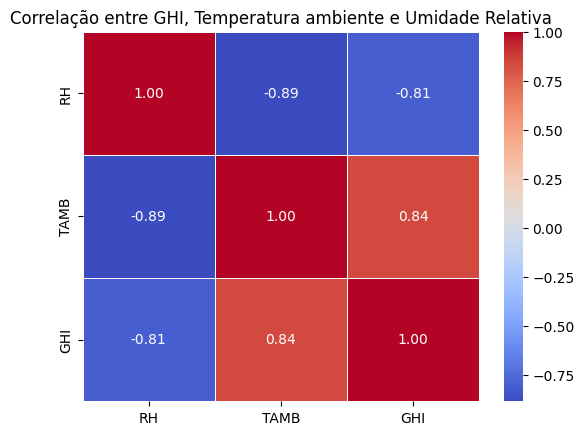

In [10]:
sns.heatmap(matriz_de_correlacao, annot=True, cmap="coolwarm", fmt=".2f",linewidths=0.5)
plt.title('Correlação entre GHI, Temperatura ambiente e Umidade Relativa')
plt.show()

In [11]:
df_mensal['TAMB_MV_6M'] = df_mensal['TAMB'].rolling(window=7, min_periods=1).mean()
df_mensal['GHI_MV_6M'] = df_mensal['GHI'].rolling(window=7,min_periods=1).mean()
df_mensal['RH_MV_6M'] = df_mensal['RH'].rolling(window=7,min_periods=1).mean()

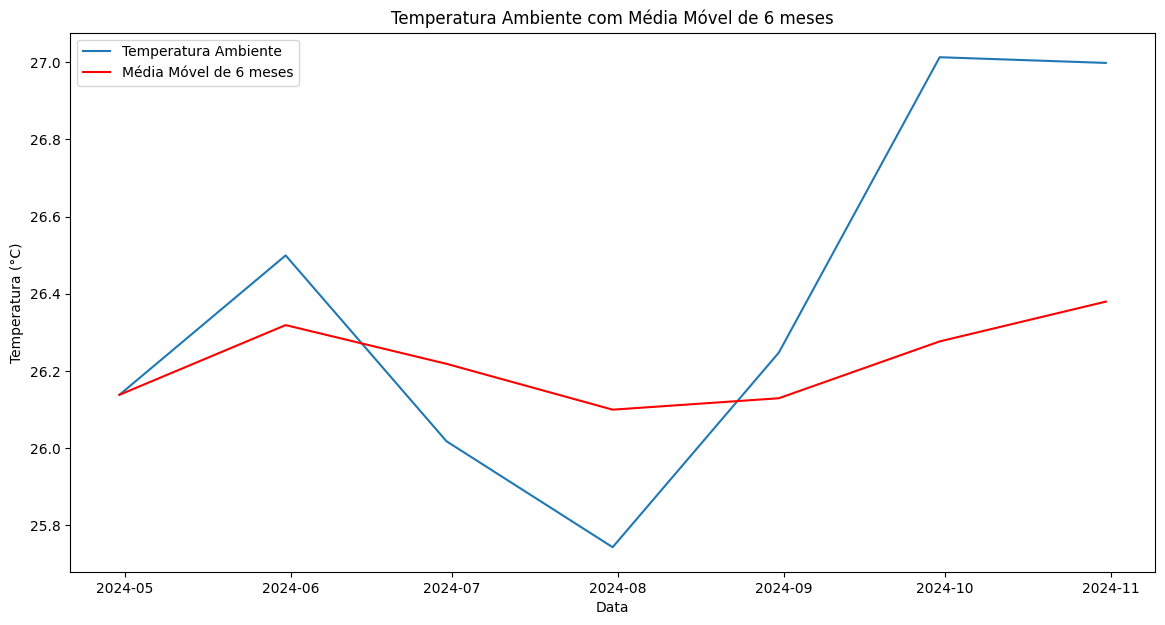

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(df_mensal.index, df_mensal['TAMB'], label='Temperatura Ambiente')
plt.plot(df_mensal.index, df_mensal['TAMB_MV_6M'], label='Média Móvel de 6 meses', color='red')
plt.title('Temperatura Ambiente com Média Móvel de 6 meses')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

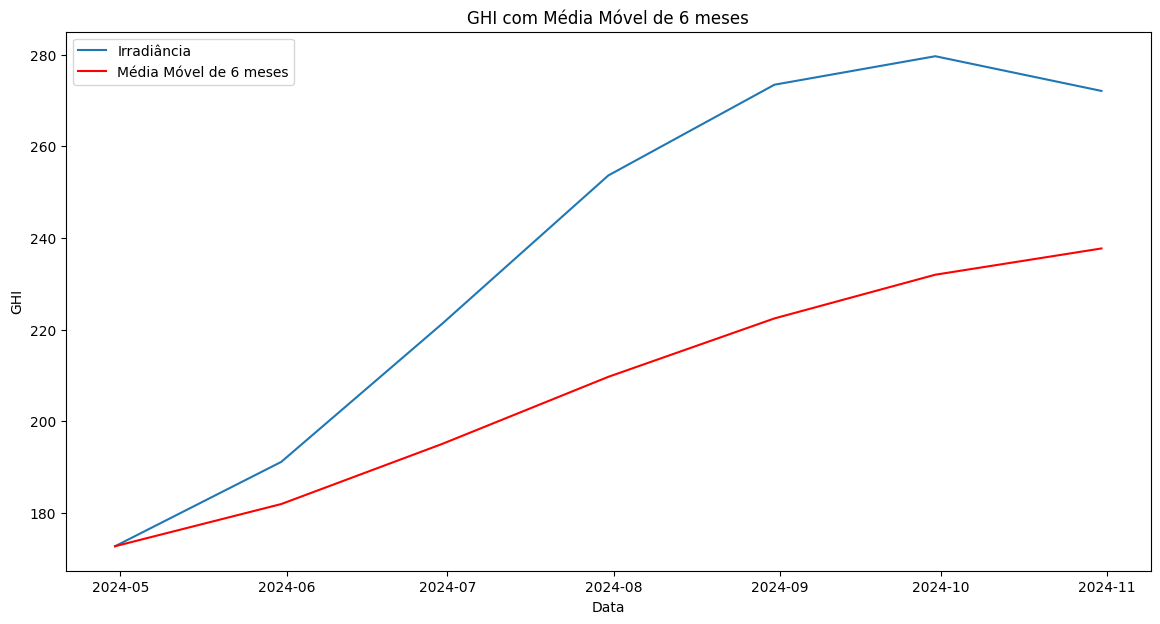

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(df_mensal.index, df_mensal['GHI'], label='Irradiância')
plt.plot(df_mensal.index, df_mensal['GHI_MV_6M'], label='Média Móvel de 6 meses', color='red')
plt.title('GHI com Média Móvel de 6 meses')
plt.xlabel('Data')
plt.ylabel('GHI')
plt.legend()
plt.show()

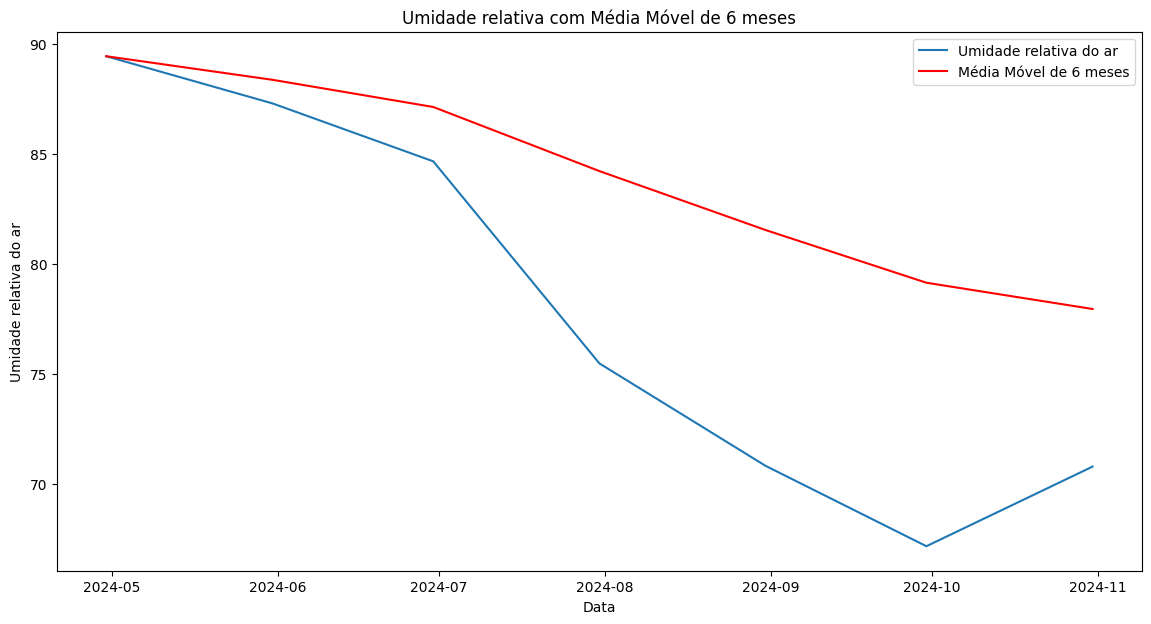

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(df_mensal.index, df_mensal['RH'], label='Umidade relativa do ar')
plt.plot(df_mensal.index, df_mensal['RH_MV_6M'], label='Média Móvel de 6 meses', color='red')
plt.title('Umidade relativa com Média Móvel de 6 meses')
plt.xlabel('Data')
plt.ylabel('Umidade relativa do ar')
plt.legend()
plt.show()

In [15]:
# Média móvel de 7 dias para suavizar oscilações semanais
df_diario['GHI_movel_7d'] = df_diario['GHI'].rolling(window=7, min_periods=1).mean()
df_diario['TAMB_movel_7d'] = df_diario['TAMB'].rolling(window=7, min_periods=1).mean()
df_diario['RH_movel_7d'] = df_diario['RH'].rolling(window=7, min_periods=1).mean()

# Média móvel de 30 dias para identificar tendências mensais
df_diario['GHI_movel_30d'] = df_diario['GHI'].rolling(window=30, min_periods=1).mean()
df_diario['TAMB_movel_30d'] = df_diario['TAMB'].rolling(window=30, min_periods=1).mean()
df_diario['RH_movel_30d'] = df_diario['RH'].rolling(window=30, min_periods=1).mean()

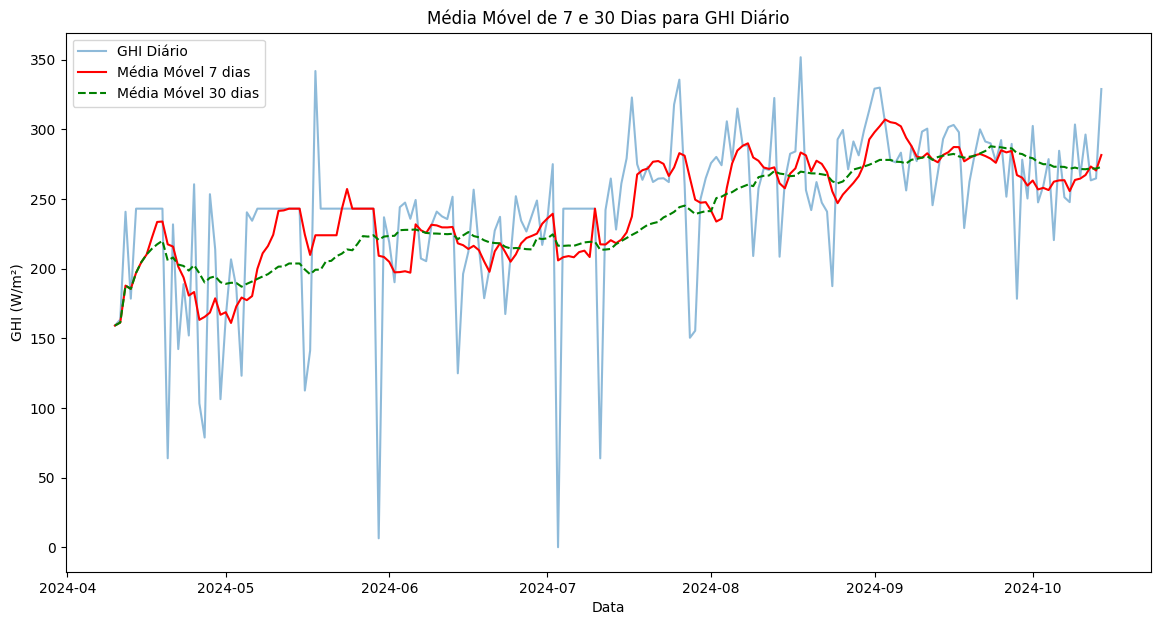

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(df_diario.index, df_diario['GHI'], label='GHI Diário', alpha=0.5)
plt.plot(df_diario.index, df_diario['GHI_movel_7d'], label='Média Móvel 7 dias', color='red')
plt.plot(df_diario.index, df_diario['GHI_movel_30d'], label='Média Móvel 30 dias', color='green', linestyle='dashed')
plt.title('Média Móvel de 7 e 30 Dias para GHI Diário')
plt.xlabel('Data')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.show()

In [24]:
# Supondo que df_mensal já esteja definido e tenha um índice de datas
df_mensal['timestamp'] = df_mensal.index.astype(np.int64) // 10**9  # Convertendo para segundos
X = df_mensal['timestamp'].values.reshape(-1, 1)  # Variável independente
y = df_mensal['GHI'].values  # Variável dependente

# Inicializar e ajustar o modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Previsões para os dados históricos
previsoes_passado = modelo.predict(X)

# Definir as datas futuras
datas_futuras = pd.to_datetime([
    "2024-11-30", "2024-12-31", "2025-01-31", "2025-02-28",
    "2025-03-31", "2025-04-30", "2025-05-31", "2025-06-30",
    "2025-07-31", "2025-08-31", "2025-09-30", "2025-10-31",
    "2025-11-30", "2025-12-31"
])

# Converter as datas futuras para timestamps em segundos
anos_futuro = datas_futuras.astype(np.int64) // 10**9
anos_futuro = anos_futuro.values.reshape(-1, 1)

# Prever os valores futuros
previsoes_futuro = modelo.predict(anos_futuro)
previsoes_futuro

array([312.74403498, 331.81239951, 350.88076404, 368.10380297,
       387.17216751, 405.6254235 , 424.69378804, 443.14704403,
       462.21540856, 481.2837731 , 499.73702909, 518.80539362,
       537.25864962, 556.32701415])

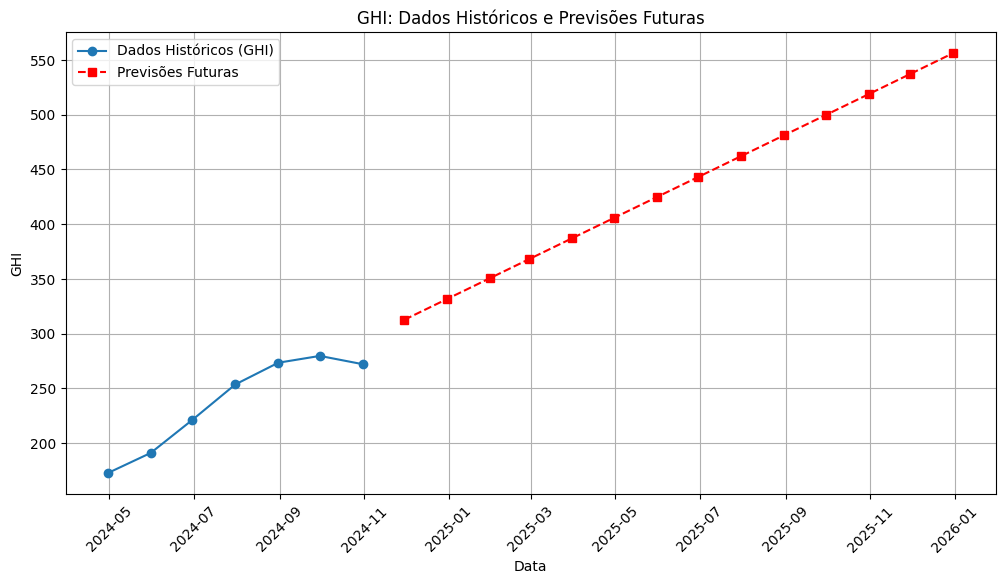

In [25]:
# Converter timestamps de volta para datas para exibição no gráfico
datas_historicas = pd.to_datetime(df_mensal.index)

# Criar um DataFrame para os dados futuros com as previsões
df_futuro = pd.DataFrame({'Data': datas_futuras, 'Previsão GHI': previsoes_futuro})

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(datas_historicas, y, label="Dados Históricos (GHI)", marker='o', linestyle='-')
plt.plot(df_futuro['Data'], df_futuro['Previsão GHI'], label="Previsões Futuras", marker='s', linestyle='--', color='red')

# Melhorar a apresentação do gráfico
plt.xlabel("Data")
plt.ylabel("GHI")
plt.title("GHI: Dados Históricos e Previsões Futuras")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()